In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

import math
from math import sqrt

from numpy import absolute
from numpy import mean
from numpy import std

from sklearn import metrics
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn import neighbors


import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.random import set_seed

import xgboost as xgb

#### There is a lot of data, which will require a lot of computing resources, so I took only a part of it


In [215]:
train = pd.read_csv(
    "./dataset/train.csv", nrows=100000, parse_dates=["pickup_datetime"]
)
test = pd.read_csv("./dataset/test.csv", parse_dates=["pickup_datetime"])

In [216]:
print(train.shape)
print(test.shape)

(100000, 8)
(9914, 7)


In [217]:
train.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [218]:
train.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [219]:
train.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  100000.000000     100000.000000    100000.000000      100000.000000   
mean       11.354652        -72.494682        39.914481         -72.490967   
std         9.716777         10.693934         6.225686          10.471386   
min       -44.900000       -736.550000       -74.007670         -84.654241   
25%         6.000000        -73.992041        40.734996         -73.991215   
50%         8.500000        -73.981789        40.752765         -73.980000   
75%        12.500000        -73.966982        40.767258         -73.963433   
max       200.000000         40.787575       401.083332          40.851027   

       dropoff_latitude  passenger_count  
count     100000.000000    100000.000000  
mean          39.919053         1.673820  
std            6.213427         1.300171  
min          -74.006377         0.000000  
25%           40.734182         1.000000  
50%           40.753243         1.000000  
75%           40.768166         2.000000  
max          404.616667         6.000000

## From this we learn that

- The minimum fare is negative, which is impossible
- Some travel points are missing the city
- The maximum number of passengers is equal to 208, which is impossible
- The maximum fare also unreal


# Data Cleaning & Feature Engineering


#### Find, if we have data that has no value


In [220]:
print(train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [221]:
train = train.dropna(how="any", axis="rows")

In [222]:
print("Old size: %d" % len(train))

Old size: 100000


#### There will be no negative tax and you may not be able to pay more than a certain limit depending on the circumstances, let's say this limit is 200\\$

Also, the minimum fare for a New York taxi is 2,50\\$


In [223]:
train = train.drop(train[train.fare_amount < 2.5].index, axis=0)
train = train.drop(train[train.fare_amount > 300].index, axis=0)

#### Delete the data whose passenger_count exceeded 6, because it cannot physically fit more in the taxi and it is not allowed. Taxi can also move without passenger and carry cargo, so lets permit passenger_count == 0 data


In [224]:
train = train.drop(train[train["passenger_count"] > 6].index, axis=0)
train = train.drop(train[train["passenger_count"] < 0].index, axis=0)

#### Remove the pickup_latitude data whose values are greater than 90 and less than -90, because latitudes are between -90 and 90 degrees


In [225]:
train = train.drop(train[train["pickup_latitude"] < -90].index, axis=0)
train = train.drop(train[train["pickup_latitude"] > 90].index, axis=0)

#### Remove the pickup_longitude data whose values are greater than 180 and less than -180, because longitudes are between -180 and 180 degrees


In [226]:
train = train.drop(train[train["pickup_longitude"] < -180].index, axis=0)
train = train.drop(train[train["pickup_longitude"] > 180].index, axis=0)

#### Repeat the same for dropoff_latitude and dropoff_longitude


In [227]:
train = train.drop(train[train["dropoff_latitude"] < -90].index, axis=0)
train = train.drop(train[train["dropoff_latitude"] > 90].index, axis=0)

train = train.drop(train[train["dropoff_longitude"] < -180].index, axis=0)
train = train.drop(train[train["dropoff_longitude"] > 180].index, axis=0)

#### The geographical location may correspond to the real one, but not to New York area, so let's filter the existing data. For this, let's introduce the conditional city limits


In [228]:
def select_outside_boundingbox(df, BB):
    filter_df = df.loc[
        (df["pickup_longitude"] < BB[0])
        | (df["pickup_longitude"] > BB[1])
        | (df["pickup_latitude"] < BB[2])
        | (df["pickup_latitude"] > BB[3])
        | (df["dropoff_longitude"] < BB[0])
        | (df["dropoff_longitude"] > BB[1])
        | (df["dropoff_latitude"] < BB[2])
        | (df["dropoff_latitude"] > BB[3])
    ]

    return filter_df


NYC_BB = (-74.5, -72.8, 40.5, 41.8)

In [229]:
outliers = select_outside_boundingbox(train, NYC_BB)
outliers

key  fare_amount           pickup_datetime  \
11      2012-12-24 11:24:00.00000098          5.5 2012-12-24 11:24:00+00:00   
15     2013-11-23 12:57:00.000000190          5.0 2013-11-23 12:57:00+00:00   
26     2011-02-07 20:01:00.000000114          6.5 2011-02-07 20:01:00+00:00   
124     2013-01-17 17:22:00.00000043          8.0 2013-01-17 17:22:00+00:00   
192     2010-09-05 17:08:00.00000092          3.7 2010-09-05 17:08:00+00:00   
...                              ...          ...                       ...   
99737    2015-03-31 15:59:56.0000009          9.0 2015-03-31 15:59:56+00:00   
99768    2015-06-15 03:49:16.0000001          6.0 2015-06-15 03:49:16+00:00   
99829    2012-04-01 17:02:00.0000005         24.9 2012-04-01 17:02:00+00:00   
99904    2010-08-14 17:56:04.0000002          6.9 2010-08-14 17:56:04+00:00   
99971  2011-01-28 21:12:00.000000109          6.1 2011-01-28 21:12:00+00:00   

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
11             0.000000          0.00000                0.0               0.0   
15             0.000000          0.00000                0.0               0.0   
26             0.000000          0.00000                0.0               0.0   
124            0.000000          0.00000                0.0               0.0   
192            0.000000          0.00000                0.0               0.0   
...                 ...              ...                ...               ...   
99737        -73.957809         40.77375                0.0               0.0   
99768          0.000000          0.00000                0.0               0.0   
99829          0.000000          0.00000                0.0               0.0   
99904          0.000000          0.00000                0.0               0.0   
99971          0.000000          0.00000                0.0               0.0   

       passenger_count  
11                   3  
15                   1  
26                   1  
124                  2  
192                  5  
...                ...  
99737                1  
99768                1  
99829                3  
99904                1  
99971                1  

[2125 rows x 8 columns]

In [230]:
train = train.drop(outliers.index, axis=0)

In [231]:
print("New size: %d" % len(train))

New size: 97858


In [233]:
test.dtypes

key                               object
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

#### We can understand displacement through start and end points.

#### We will use the Haversine formula to calculate the distance between two geolocations


In [234]:
train["loc1"] = train[["pickup_latitude", "pickup_longitude"]].apply(tuple, axis=1)
train["loc2"] = train[["dropoff_latitude", "dropoff_longitude"]].apply(tuple, axis=1)

In [235]:
import haversine as hs


train["H_Distance"] = train.apply(lambda row: hs.haversine(row.loc1, row.loc2), axis=1)

#### Let's also calculate the distance using the Chebyshev method


In [236]:
def chebyshev(pickup_long, dropoff_long, pickup_lat, dropoff_lat):
    return np.maximum(
        np.absolute(pickup_long - dropoff_long), np.absolute(pickup_lat - dropoff_lat)
    )


train["Chebyshev"] = chebyshev(
    train["pickup_longitude"],
    train["dropoff_longitude"],
    train["pickup_latitude"],
    train["dropoff_latitude"],
)

In [237]:
train.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count                     loc1                     loc2  \
0                1  (40.721319, -73.844311)   (40.712278, -73.84161)   
1                1  (40.711303, -74.016048)  (40.782004, -73.979268)   
2                2   (40.76127, -73.982738)  (40.750562, -73.991242)   
3                1   (40.733143, -73.98713)  (40.758092, -73.991567)   
4                1  (40.768008, -73.968095)  (40.783762, -73.956655)   

   H_Distance  Chebyshev  
0    1.030765   0.009041  
1    8.450145   0.070701  
2    1.389527   0.010708  
3    2.799274   0.024949  
4    1.999160   0.015754

In [238]:
train["hour"] = train.pickup_datetime.dt.hour
train["day_of_week"] = train.pickup_datetime.dt.weekday
train["day_of_month"] = train.pickup_datetime.dt.day
train["week"] = train.pickup_datetime.dt.isocalendar().week
train["month"] = train.pickup_datetime.dt.month
train["year"] = train.pickup_datetime.dt.year - 2000

train["minute"] = train["pickup_datetime"].dt.minute
train["second"] = train["pickup_datetime"].dt.second
train["dayofyear"] = train["pickup_datetime"].dt.dayofyear

In [239]:
train.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count                     loc1                     loc2  ...  \
0                1  (40.721319, -73.844311)   (40.712278, -73.84161)  ...   
1                1  (40.711303, -74.016048)  (40.782004, -73.979268)  ...   
2                2   (40.76127, -73.982738)  (40.750562, -73.991242)  ...   
3                1   (40.733143, -73.98713)  (40.758092, -73.991567)  ...   
4                1  (40.768008, -73.968095)  (40.783762, -73.956655)  ...   

   Chebyshev  hour  day_of_week  day_of_month  week  month  year  minute  \
0   0.009041    17            0            15    25      6     9      26   
1   0.070701    16            1             5     1      1    10      52   
2   0.010708     0            3            18    33      8    11      35   
3   0.024949     4            5            21    16      4    12      30   
4   0.015754     7            1             9    10      3    10      51   

   second  dayofyear  
0      21        166  
1      16          5  
2       0        230  
3      42        112  
4       0         68  

[5 rows x 21 columns]

#### Add a variable that determines how much each kilometer of travel costs


In [240]:
train["fare_to_dist_ratio"] = train["fare_amount"] / (train["H_Distance"] + 0.0001)

#### Remove those whose start and end points match


In [241]:
train = train.drop(train[train["loc1"] == train["loc2"]].index, axis=0)

#### It is necessary to take into account the circumstances of calling at the airport, according to which the fee changes dramatically. For this, let's write the given function that shows how many kilometers away the point is from the airport


In [242]:
def add_distances_from_airport(dataset):
    # coordinates of all these airports
    jfk_coords = (40.639722, -73.778889)
    ewr_coords = (40.6925, -74.168611)
    lga_coords = (40.77725, -73.872611)

    dataset["pickup_jfk_distance"] = dataset.apply(
        lambda row: hs.haversine(jfk_coords, row.loc1), axis=1
    )
    dataset["dropof_jfk_distance"] = dataset.apply(
        lambda row: hs.haversine(jfk_coords, row.loc2), axis=1
    )

    dataset["pickup_ewr_distance"] = dataset.apply(
        lambda row: hs.haversine(ewr_coords, row.loc1), axis=1
    )
    dataset["dropof_ewr_distance"] = dataset.apply(
        lambda row: hs.haversine(ewr_coords, row.loc2), axis=1
    )

    dataset["pickup_lga_distance"] = dataset.apply(
        lambda row: hs.haversine(lga_coords, row.loc1), axis=1
    )
    dataset["dropof_lga_distance"] = dataset.apply(
        lambda row: hs.haversine(lga_coords, row.loc2), axis=1
    )

    return dataset


train = add_distances_from_airport(train)

### Let's repeat the same procedures on the test part


In [243]:
test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"])

test["loc1"] = test[["pickup_latitude", "pickup_longitude"]].apply(tuple, axis=1)
test["loc2"] = test[["dropoff_latitude", "dropoff_longitude"]].apply(tuple, axis=1)

test["H_Distance"] = test.apply(lambda row: hs.haversine(row.loc1, row.loc2), axis=1)

test["Chebyshev"] = chebyshev(
    test["pickup_longitude"],
    test["dropoff_longitude"],
    test["pickup_latitude"],
    test["dropoff_latitude"],
)


test["hour"] = test.pickup_datetime.dt.hour
test["day_of_week"] = test.pickup_datetime.dt.weekday
test["day_of_month"] = test.pickup_datetime.dt.day
test["week"] = test.pickup_datetime.dt.isocalendar().week
test["month"] = test.pickup_datetime.dt.month
test["year"] = test.pickup_datetime.dt.year - 2000

test["minute"] = test["pickup_datetime"].dt.minute
test["second"] = test["pickup_datetime"].dt.second
test["dayofyear"] = test["pickup_datetime"].dt.dayofyear

test = add_distances_from_airport(test)

In [244]:
def downcast(df):
    df_int = df.select_dtypes(include=["int64", "int32", "int16", "int8", "int"])
    df[df_int.columns] = df_int.apply(pd.to_numeric, downcast="unsigned")

    df_float = df.select_dtypes(include=["float64", "float32", "float16", "float"])
    df[df_float.columns] = df_float.apply(pd.to_numeric, downcast="float")

    return df


downcast(train)
downcast(test)
train.dtypes

key                                 object
fare_amount                        float32
pickup_datetime        datetime64[ns, UTC]
pickup_longitude                   float32
pickup_latitude                    float32
dropoff_longitude                  float32
dropoff_latitude                   float32
passenger_count                      uint8
loc1                                object
loc2                                object
H_Distance                         float32
Chebyshev                          float32
hour                                 uint8
day_of_week                          uint8
day_of_month                         uint8
week                                UInt32
month                                uint8
year                                 uint8
minute                               uint8
second                               uint8
dayofyear                           uint16
fare_to_dist_ratio                 float64
pickup_jfk_distance                float32
dropof_jfk_

## Map visualization


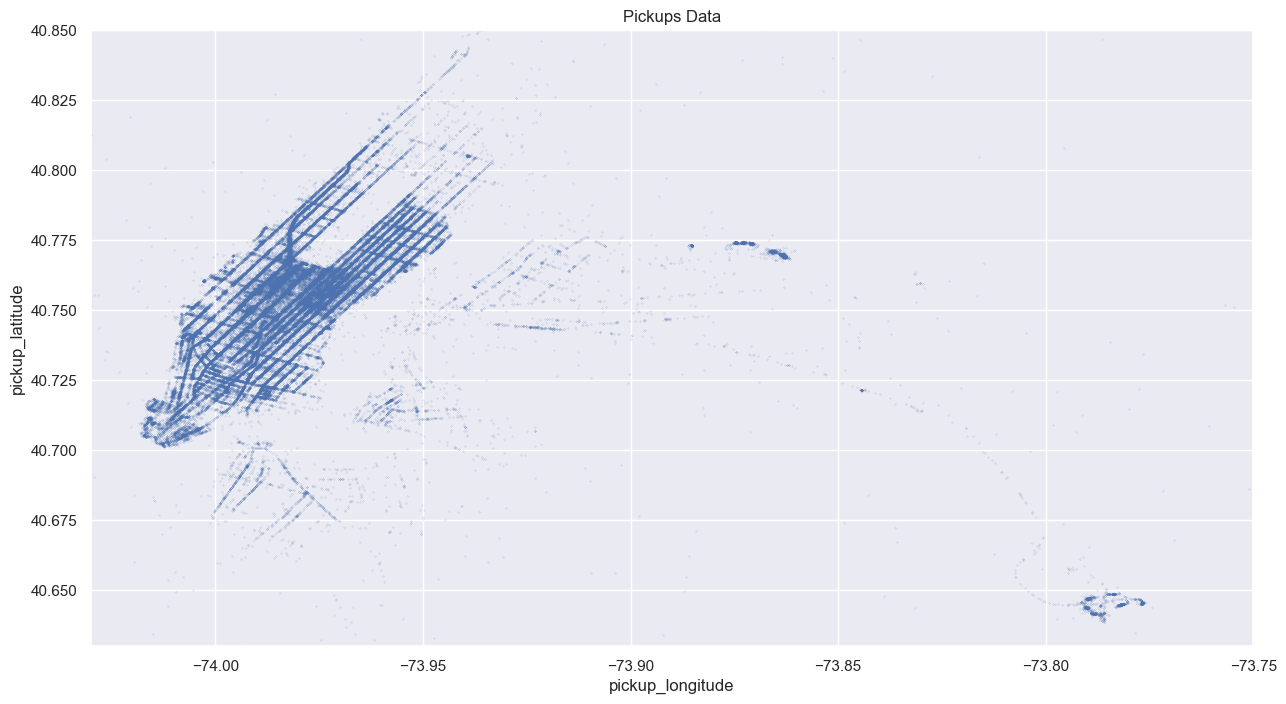

In [245]:
train.plot(y="pickup_latitude", x="pickup_longitude", kind="scatter", alpha=0.7, s=0.02)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.title("Pickups Data")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

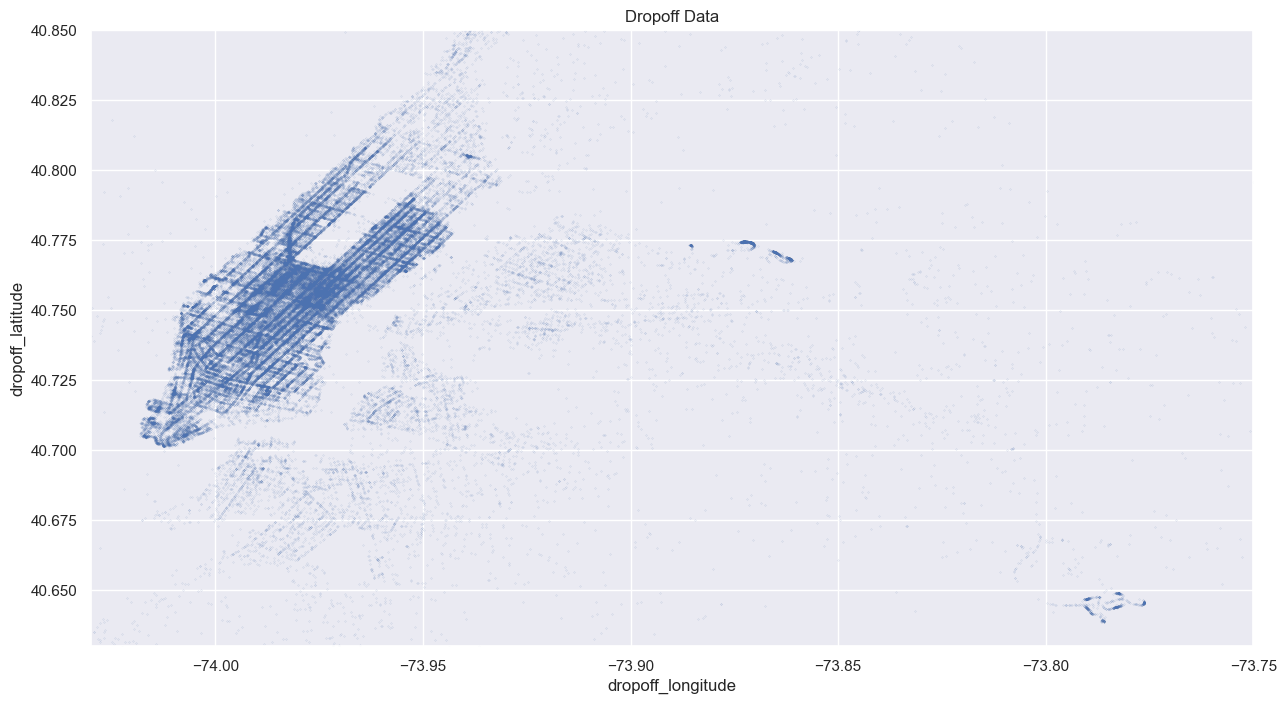

In [246]:
train.plot(
    y="dropoff_latitude", x="dropoff_longitude", kind="scatter", alpha=0.5, s=0.02
)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.title("Dropoff Data")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [247]:
import folium


long_trips = train[train["H_Distance"] >= 10]

drop_map = folium.Map(location=[40.730610, -73.935242], zoom_start=12)

for index, row in long_trips.iterrows():
    folium.CircleMarker(
        [row["dropoff_latitude"], row["dropoff_longitude"]],
        radius=3,
        color="green",
        fill_opacity=0.9,
    ).add_to(drop_map)
for index, row in long_trips.iterrows():
    folium.CircleMarker(
        [row["pickup_latitude"], row["pickup_longitude"]],
        radius=3,
        color="blue",
        fill_opacity=0.9,
    ).add_to(drop_map)
drop_map

## EDA


/Users/rudra/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 100.0)

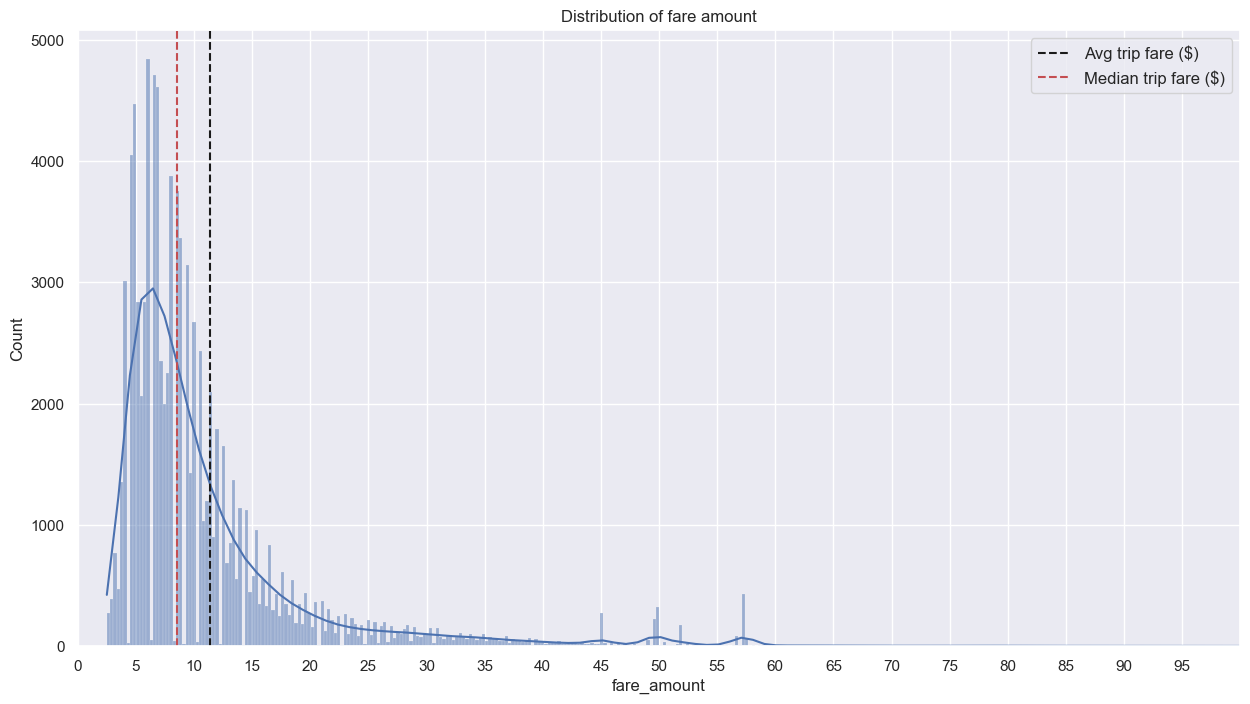

In [248]:
sns.histplot(data=train, x="fare_amount", kde=True)

plt.axvline(
    train["fare_amount"].mean(),
    color="k",
    linestyle="dashed",
    label="Avg trip fare ($)",
)
plt.axvline(
    train["fare_amount"].median(),
    color="r",
    linestyle="dashed",
    label="Median trip fare ($)",
)

plt.title("Distribution of fare amount")
plt.xticks(np.arange(0, 100, step=5))
plt.legend(loc="best", prop={"size": 12})
plt.gcf().set_size_inches(15, 8)
plt.xlim(0, 100)

##### A right-skewed distribution

- #### Most taxi fares range from $2.5\\$-20\\$.
- #### The average taxi fee varies between 10\\$-12\\$
- #### 45\\$-50\\$-57\\$ peaks are observed, which fixed fee


/Users/rudra/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 30.0)

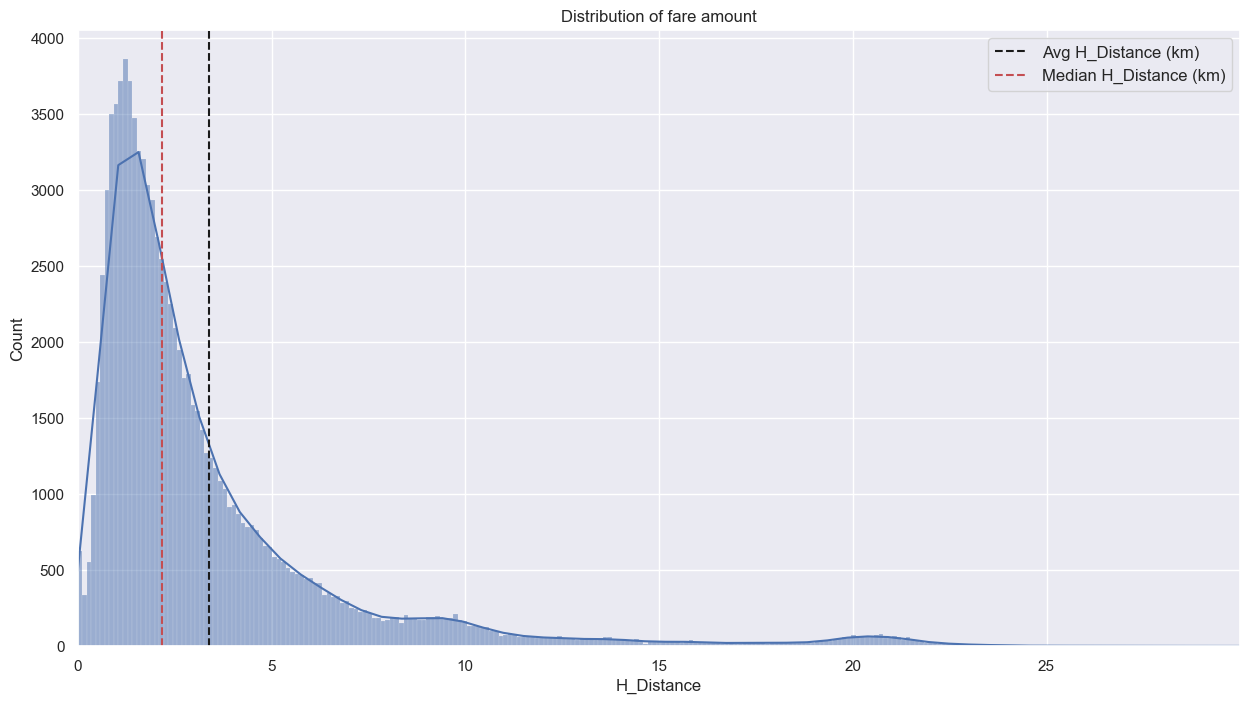

In [249]:
sns.histplot(data=train, x="H_Distance", kde=True)

plt.axvline(
    train["H_Distance"].mean(),
    color="k",
    linestyle="dashed",
    label="Avg H_Distance (km)",
)
plt.axvline(
    train["H_Distance"].median(),
    color="r",
    linestyle="dashed",
    label="Median H_Distance (km)",
)

plt.title("Distribution of fare amount")
plt.xticks(np.arange(0, 30, step=5))
plt.legend(loc="best", prop={"size": 12})
plt.gcf().set_size_inches(15, 8)
plt.xlim(0, 30)

- #### Passengers travel an average of 3-5 km by taxi


#### 1. Does the number of passengers affect the fare?


/Users/rudra/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

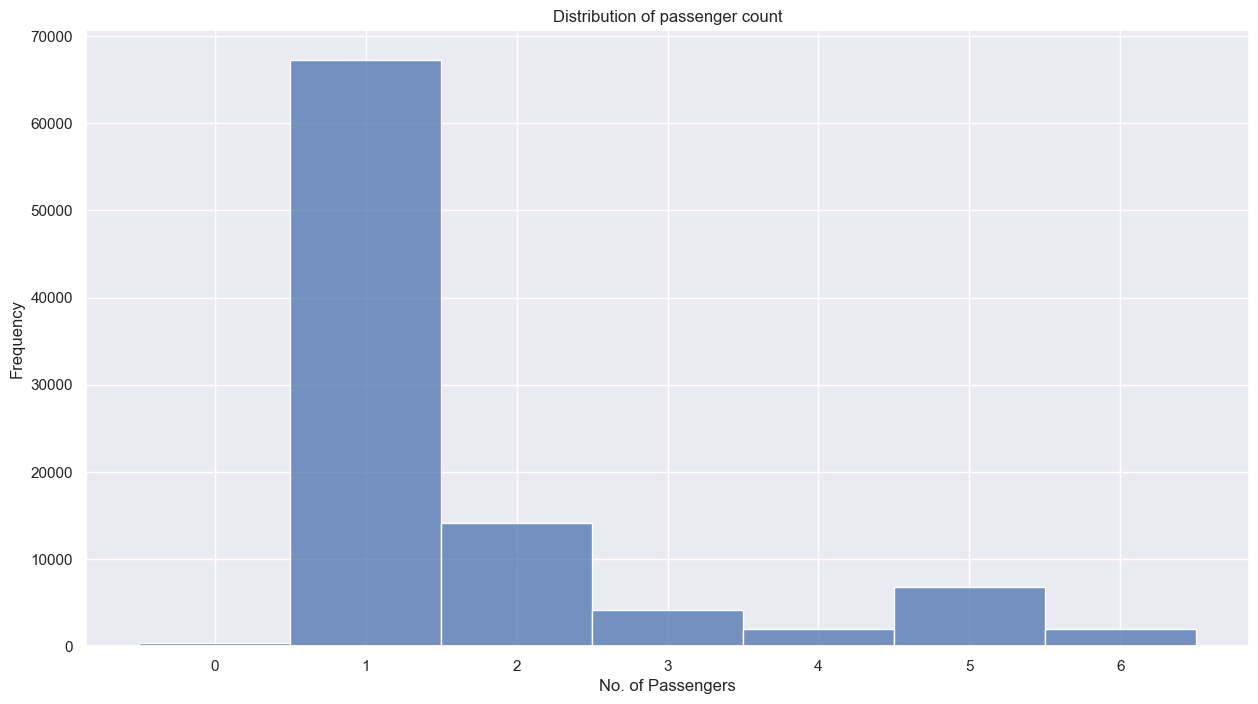

In [250]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.histplot(data=train, x="passenger_count", stat="count", discrete=True)
plt.title("Distribution of passenger count")
plt.xlabel("No. of Passengers")
plt.ylabel("Frequency")

- #### Most of the passengers were traveling alone


Text(0, 0.5, 'Fare')

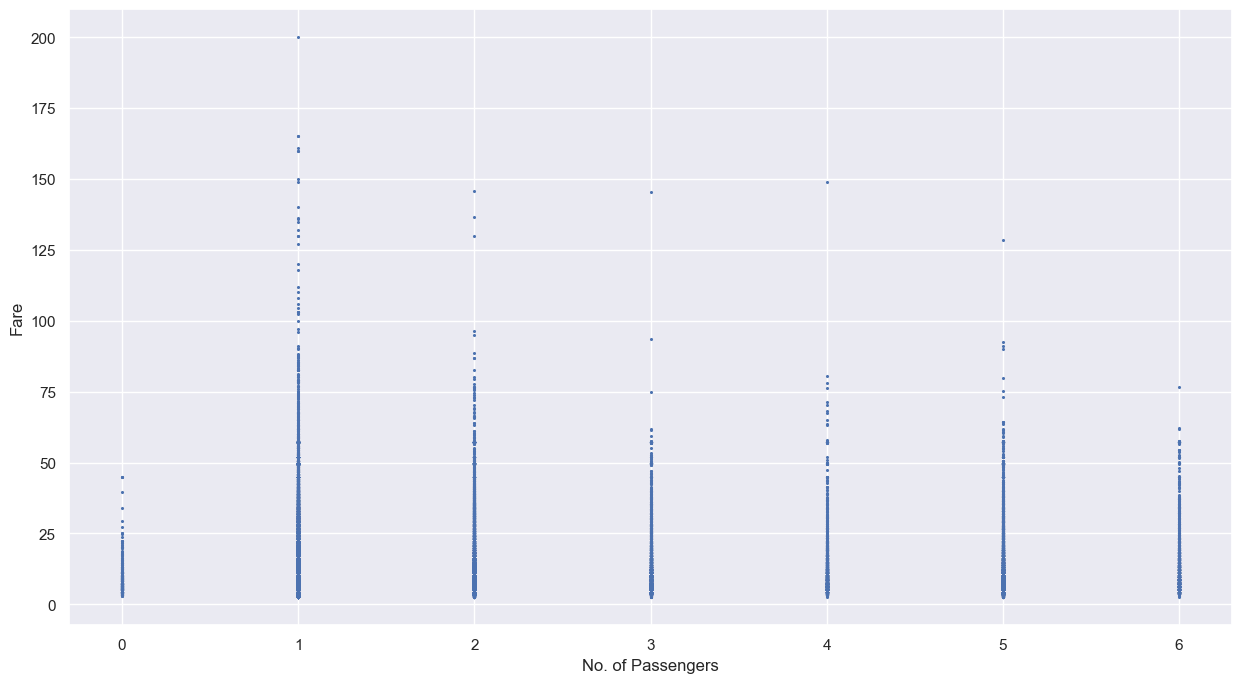

In [251]:
plt.figure(figsize=(15, 8))
plt.scatter(x=train["passenger_count"], y=train["fare_amount"], s=1.5)
plt.xlabel("No. of Passengers")
plt.ylabel("Fare")

- #### One-passenger taxi has more passengers whose fare is higher


In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(
    train.corr(),
    linewidths=0.1,
    vmax=1.0,
    vmin=0,
    square=True,
    cmap=colormap,
    linecolor="white",
    annot=True,
)
heatmap.set_title("Correlation Heatmap", fontdict={"fontsize": 12}, pad=12)

In [ ]:
plt.figure(figsize=(15, 8))
plt.scatter(x=train["year"], y=train["fare_amount"], s=1.5)
plt.xlabel("Years")
plt.ylabel("Fare")

In [ ]:
train[["fare_amount", "year"]].corr()

- #### The rate does not change significantly over the years


In [ ]:
plt.figure(figsize=(15, 8))
plt.scatter(x=train["month"], y=train["fare_amount"], s=1.5)
plt.xlabel("Month")
plt.ylabel("Fare")

- #### The rate is uniform throughout the months


In [ ]:
plt.figure(figsize=(15, 8))
plt.scatter(x=train["day_of_month"], y=train["fare_amount"], s=1.5)
plt.xlabel("Days")
plt.ylabel("Fare")

- #### The fare is uniform throughout the month


In [ ]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.histplot(data=train, x="hour", stat="count", discrete=True, kde=True)
plt.title("Distribution by Hours")
plt.xlabel("Hours")
plt.ylabel("Frequency")

- #### Taxi fares are rare at 5am and reaches the maximum at 7pm


In [ ]:
plt.figure(figsize=(15, 7))
plt.scatter(x=train["hour"], y=train["fare_amount"], s=1.5)
plt.xlabel("Hour")
plt.ylabel("Fare")

In [ ]:
train[train.passenger_count < 7][["fare_amount", "passenger_count"]].corr()

In [ ]:
def time_slicer(df, timeframes, value, color="purple"):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize=[12, 12])
    for i, x in enumerate(timeframes):
        df.loc[:, [x, value]].groupby([x]).mean().plot(ax=ax[i], color=color)
        ax[i].set_ylabel(value.replace("_", " ").title())
        ax[i].set_title(
            "{} by {}".format(
                value.replace("_", " ").title(), x.replace("_", " ").title()
            )
        )
        ax[i].set_xlabel("")
    plt.tight_layout(pad=0)

In [ ]:
time_slicer(
    df=train,
    timeframes=[
        "hour",
        "day_of_week",
        "day_of_month",
        "week",
        "month",
        "year",
    ],
    value="fare_amount",
    color="blue",
)

- #### The higher the demand, the lower the fee and vice versa
- #### Average fares peak on Mondays and Thursdays
- #### The average fee has been increasing over the years


In [ ]:
time_slicer(
    df=train,
    timeframes=[
        "hour",
        "day_of_week",
        "day_of_month",
        "week",
        "month",
        "year",
    ],
    value="H_Distance",
    color="green",
)

In [ ]:
train[["fare_amount", "H_Distance"]].corr()

- #### The correlation number between these two values is high, as a result the graphs are very similar to each other
- #### At 5 o'clock in the morning, some people who have a long distance to travel leave home early, but they are not many, so the fare increases.


In [ ]:
time_slicer(
    df=train,
    timeframes=[
        "hour",
        "day_of_week",
        "day_of_month",
        "week",
        "month",
        "year",
    ],
    value="fare_to_dist_ratio",
    color="red",
)

- #### The price of 1 km is high at the beginning of the day and decreases during the day
- #### The price of 1 km increases during the week
- #### The price of 1 km decreases during the months


In [ ]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].scatter(train.H_Distance, train.fare_amount, alpha=0.2)
axs[0].set_xlabel("H_Distance mile")
axs[0].set_ylabel("fare $USD")
axs[0].set_title("All data")

# zoom in on part of data
idx = (train.H_Distance < 30) & (train.fare_amount < 100)
axs[1].scatter(train[idx].H_Distance, train[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel("H_Distance mile")
axs[1].set_ylabel("fare $USD")
axs[1].set_title("Zoom in on distance < 30 mile, fare < $100")

In [ ]:
print(
    "Average $USD/Km : {:0.2f}".format(train.fare_amount.sum() / train.H_Distance.sum())
)

- #### The horizontal lines on the graph to the right may indicate fixed fares from the airport
- #### Overall, a linear relationship is observed


In [ ]:
train.reset_index(drop=True, inplace=True)

train[train["fare_to_dist_ratio"] > 500]

In [ ]:
passenger_fare = train.groupby(["passenger_count"]).mean()
sns.barplot(x=passenger_fare.index, y=passenger_fare["fare_amount"], palette="Set3")
plt.xlabel("Number of Passengers")
plt.ylabel("Average Fare Price")
plt.title("Average Fare Price for Number of Passengers")
plt.show()

# Data Preprocess


In [ ]:
train.drop(
    ["key", "pickup_datetime", "loc1", "loc2", "fare_to_dist_ratio"],
    axis=1,
    inplace=True,
)

test_key = pd.DataFrame(test["key"])
test.drop(
    [
        "key",
        "pickup_datetime",
        "loc1",
        "loc2",
    ],
    axis=1,
    inplace=True,
)

In [ ]:
print(train.dtypes)
print(test.dtypes)

#### Split Data


In [ ]:
X = train.iloc[:, train.columns != "fare_amount"]
y = train["fare_amount"]
X_test = test
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.75, test_size=0.15, random_state=42, shuffle=True
)

## Model 1 : Linear Regression


In [ ]:
def Linear_reg(X_train, X_valid, y_train, y_valid):
    linear = LinearRegression()
    linear.fit(X_train, y_train)

    y_train_predict = linear.predict(X_train)
    r2_train = r2_score(y_train, y_train_predict)
    RMSE_train = mean_squared_error(y_train, y_train_predict, squared=False)

    y_valid_predict = linear.predict(X_valid)
    r2_valid = r2_score(y_valid, y_valid_predict)
    RMSE_valid = mean_squared_error(y_valid, y_valid_predict, squared=False)

    return r2_train, r2_valid, linear, RMSE_train, RMSE_valid


r2_train, r2_valid, linear, RMSE_train, RMSE_valid = Linear_reg(
    X_train, X_valid, y_train, y_valid
)

# print("R^2 (train) : ", r2_train)
print("RMSE (train): ", RMSE_train)
# print("R^2 (valid) : ", r2_valid)
print("RMSE (valid): ", RMSE_valid)

- RMSE (train): 1.3202917e-05
- RMSE (valid): 1.4740558


## Model 2 : Polynomial Regression


In [ ]:
def Poly_reg(X_train, X_valid, y_train, y_valid, degree={"degree": 2}):
    poly = PolynomialFeatures(degree=degree["degree"])
    X_train_ = poly.fit_transform(X_train)
    est_poly = LinearRegression()
    est_poly.fit(X_train_, y_train)

    y_train_predict = est_poly.predict(X_train_)
    r2_train = r2_score(y_train, y_train_predict)
    RMSE_train = mean_squared_error(y_train, y_train_predict, squared=False)

    X_valid_ = poly.fit_transform(X_valid)

    y_valid_predict = est_poly.predict(X_valid_)
    r2_valid = r2_score(y_valid, y_valid_predict)
    RMSE_valid = mean_squared_error(y_valid, y_valid_predict, squared=False)

    return r2_train, r2_valid, RMSE_train, RMSE_valid


for deg in range(1, 5):
    degree = {"degree": deg}
    r2_train, r2_valid, RMSE_train, RMSE_valid = Poly_reg(
        X_train, X_valid, y_train, y_valid, degree
    )
    print("Polynomial degree", deg)
    print("R^2 (train) : ", r2_train)
    print("RMSE (train): ", RMSE_train)
    print("R^2 (valid) : ", r2_valid)
    print("RMSE (valid): ", RMSE_valid)

- Polynomial degree 1
- R^2 (train) : 0.9999999999953564
- RMSE (train): 2.0643134e-05
- R^2 (valid) : 0.3986446655631378
- RMSE (valid): 7.342692
- Polynomial degree 2
- R^2 (train) : 0.9999999998963758
- RMSE (train): 9.751603e-05
- R^2 (valid) : 0.40283202490610714
- RMSE (valid): 7.317083
- Polynomial degree 3
- R^2 (train) : 0.999999991415696
- RMSE (train): 0.00088756054
- R^2 (valid) : 0.39955006653268765
- RMSE (valid): 7.3371625


## Model 2 : Ridge Regression


In [ ]:
model = Ridge(alpha=1.0)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(
    model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1
)
scores = absolute(scores)
print("rmse: %.3f (%.3f)" % (mean(scores), std(scores)))

rmse: 0.041 (0.003)


## Model 3: DECISION TREE REGRESSOR MODEL


In [ ]:
dtr = DecisionTreeRegressor().fit(X_train, y_train)
y_valid_pred = dtr.predict(X_valid)


# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print("RMSE: %f" % (rmse))

# Mean Squared Error
print("Mean squared error: %.2f" % mean_squared_error(y_valid, y_valid_pred))

# R2 Score
print("Variance score: %.2f" % r2_score(y_valid, y_valid_pred))

- RMSE: 1.474739
- Mean squared error: 2.17
- Variance score: 0.98
- when size = 1000000


## Model 4: Neural Network


In [ ]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-3, patience=3)
callback = [early_stop]
adam = Adam(lr=0.0001)

model = Sequential()
model.add(Dense(100, activation="relu", input_shape=(train.shape[1],)))
model.add(Dropout(0.6))
model.add(Dense(80, activation="relu"))
model.add(Dropout(0.6))
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.6))
model.add(Dense(1, activation="linear"))
model.compile(loss="mse", optimizer=adam, metrics=["mae"])
history = model.fit(
    X_train,
    y_train,
    batch_size=256,
    epochs=50,
    verbose=1,
    callbacks=callback,
    validation_data=(X_valid, y_valid),
    shuffle=True,
)

In [ ]:
# summarize history for loss using learning curve
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
y_pred = np.array(model.predict(X_valid))
print(mean_squared_error(y_valid, y_pred))
print(sqrt(mean_squared_error(y_valid, y_pred)))